In [382]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy.special import expit, gamma

def compute_cpg_posterior(w, b, phi, c, prior_c, t=None, x=None, normalized=True):
    t = t if t is not None else np.linspace(-100, 100, 100)[:, None]
    x = x if x is not None else np.linspace(0.01, 0.99, 100)[None, :]
    assert len(t.shape) == 2, 't is expected to be column vector \in 2D' 
    assert len(x.shape) == 2, 't is expected to be row vector \in 2D' 
    dt = t[1, 0] - t[0, 0]
    dx = x[0, 1] - x[0, 0]

    mu = expit(w*t + b)
    alpha = mu * phi
    beta = -mu * phi + phi
    B = gamma(alpha) * gamma(beta) / gamma(alpha + beta)
    pt = np.ones_like(t) * 1 / (t[-1] - t[0]) # P(t)    
    px = x**(alpha-1) * (1 - x)**(beta-1) / B # P(p|t)
    likelihood = mu ** c * (1 - mu) ** (1 - c)
    posterior = likelihood * px * pt / prior_c
    marginal_posterior = posterior.sum(1) * dx 
    if normalized:
        marginal_posterior = marginal_posterior / (marginal_posterior.sum() * dt)
    return t.ravel(), marginal_posterior


In [424]:
top = 5000
clocks = pd.read_csv('clock_data/beta.csv') 
top_idx_pos = clocks['Age-pvalue'].sort_values(ascending=True)[:top].index
top_idx = top_idx_pos.tolist()
top_sites = clocks.loc[top_idx]
top_sites

/tmp/ipykernel_4116/267271956.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top_idx_pos = clocks['Age-pvalue'].sort_values(ascending=True)[:top].index


,ChrPos,PearsonR,PearsonP,Coef,Intercept,Precision,Age-pvalue,Precision-pvalue,Log-Likelihood,AIC,BIC
423606,chr4_147443094,0.273295,1.832241e-10,0.0350,-3.0483,2.9519,0.000,0.0,926.86,-1848.0,-1835.0
400475,chr4_81442439,0.239432,1.387620e-08,0.0229,-4.8924,3.9810,0.000,0.0,2107.50,-4209.0,-4196.0
341683,chr2_138256822,0.237782,4.864221e-08,0.0232,-4.3139,3.4241,0.000,0.0,1675.20,-3344.0,-3332.0
281078,chr18_64332179,0.123794,2.223050e-02,0.0353,-3.2160,2.5705,0.000,0.0,657.67,-1309.0,-1298.0
380096,chr3_118435325,0.213593,3.030527e-04,0.0378,-2.8010,2.6078,0.000,0.0,417.73,-829.5,-818.5
...,...,...,...,...,...,...,...,...,...,...,...
284691,chr18_77456602,-0.139868,1.239759e-02,-0.0266,3.2350,2.8386,0.001,0.0,636.96,-1268.0,-1257.0
625226,chr2_18688862,0.249825,3.002714e-06,0.0235,-3.8163,2.8130,0.001,0.0,973.22,-1940.0,-1929.0
621803,chr15_103059449,0.185722,9.089334e-04,0.0228,-3.0227,2.6746,0.001,0.0,580.43,-1155.0,-1144.0
37968,chr10_3621588,-0.165122,4.766597e-04,-0.0210,3.3352,3.0719,0.001,0.0,951.48,-1897.0,-1885.0


Write Bayes formula for one CpG:
$$
    P(t, \hat{p}|CpG_i) = \frac{P(CpG_i|\hat{p}, t)P(\hat{p}|t)P(t)}{P(CpG_i)}
$$

Marginalization over $\hat{p}$ leads to the marginal posterior distribution of $t$, namely:
$$
    P(t|CpG_i) = \int_0^1 P(t, \hat{p}|CpG_i)d\hat{p}
$$

87.55020080321287

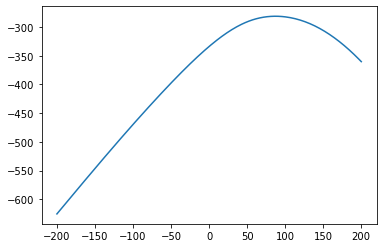

In [452]:
posteriors = []
for i in range(50):
    c = np.random.binomial(1, 0.22)
    w, b, phi = (top_sites.iloc[i]['Coef'], 
                top_sites.iloc[i]['Intercept'], 
                top_sites.iloc[i]['Precision'])
    pc = 0.22
    t = np.linspace(-200, 200, 250)[:, None]
    t, marginal_posterior = compute_cpg_posterior(w, b, phi, c, pc, t=t)
    posteriors.append(marginal_posterior)
logp = np.log(np.array(posteriors)).sum(0)

plt.plot(t, logp)
t[np.argmax(logp)]

array([-39.3258427])

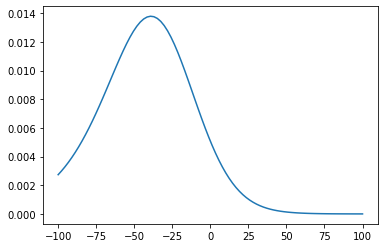

In [117]:
c = 1 #np.random.randint(0, 2)
i = 5
t = np.linspace(-100, 100, 90)[:, None]
dt = t[1] - t[0]
x = np.linspace(0.01, 0.99, 100)[None, :]
dx = x[:, 1] - x[:, 0]
w, b, phi = (top_sites.iloc[i]['Coef'], 
            top_sites.iloc[i]['Intercept'], 
            top_sites.iloc[i]['Precision'])

pc = 0.5

pt = np.ones_like(t) * 1 / (t[-1] - t[0])
mu = expit(w*t + b)
alpha = mu * phi
beta = -mu * phi + phi
B = gamma(alpha) * gamma(beta) / gamma(alpha + beta)

px = x**(alpha-1) * (1 - x)**(beta-1) / B
likelihood = mu ** c * (1 - mu) ** (1 - c)
posterior = likelihood * px * pt / pc
marginal_posterior = posterior.sum(1) * dx
marginal_posterior = marginal_posterior / (marginal_posterior.sum() * dt)

plt.plot(t, marginal_posterior)
t[np.argmax(marginal_posterior)]

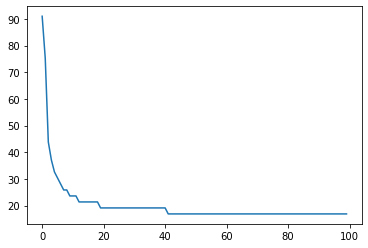

In [67]:
plt.plot(convergence)

In [ ]:

m_cells = 100
interval_of_search = (-20, 50)

#get weights and biases
w_ = np.asarray(top_sites['Coef'])
b_ = np.asarray(top_sites['Intercept'])

probs = np.zeros((m_cells, n_steps))
x = np.linspace(interval_of_search[0], interval_of_search[1], n_steps)
data = pd.DataFrame({'Ages':[], 'p':[]})
for p_met in np.linspace(0, 1.0, 12):
    for cell in range(m_cells):
        mask = np.random.binomial(1, p=p_met, size=top).astype(bool)
        for i, xi in enumerate(x):
            p = expit(w_ * xi + b_)
            p = np.where(mask, p, 1-p)
            probs[cell, i] = np.log(p).sum()

    x_opt = np.array([x[i] for i in np.argmax(probs, axis=1)])
    data = pd.concat([data, pd.DataFrame({'Ages':x_opt, "p":round(p_met, 2)})])

In [143]:


p1 = np.random.randn(1000)
p2 = np.random.randn(1000) + 10

(p1 + p2).mean()

10.016038048332547

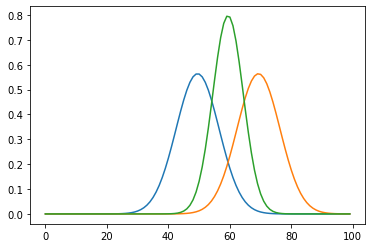

In [151]:
x = np.linspace(-5,5, 100)
dx = x[1] - x[0]
p1 = np.exp(-x**2)
p1 /= (p1.sum() * dx)
p2 = np.exp(-(x-2)**2)
p2 /= (p2.sum() * dx)

p12 = p1 * p2
p12 = p12/(p12.sum() * dx)

plt.plot(p1)
plt.plot(p2)
plt.plot(p12)